In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



from src.model_unet_no_attention import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
train_data = torch.load("../data/prepared_datasets/train_celeba.pt")
train_labels = torch.load("../data/prepared_datasets/train_celeba_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_celeba.pt")
val_labels = torch.load("../data/prepared_datasets/val_celeba_labels.pt")
test_data = torch.load("../data/prepared_datasets/test_celeba.pt")
test_labels = torch.load("../data/prepared_datasets/test_celeba_labels.pt")

In [3]:
train_data.shape

torch.Size([162770, 3, 64, 64])

In [4]:
train_data=train_data[:30000]
train_labels=train_labels[:30000]

In [5]:
batch_size = 32

In [6]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [7]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [9]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [10]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [11]:
from torchvision.utils import save_image

epochs = 40
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber")
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()
            
            # save generated images
            if batch_idx != 0 and batch_idx % save_and_sample_every == 0:
                milestone = batch_idx // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
                all_images = torch.cat(all_images_list, dim=0)
                all_images = (all_images + 1) * 0.5
                save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1/40:   0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.4828736186027527


Epoch 1/40:  11%|█         | 101/938 [00:13<01:45,  7.92it/s]

Loss: 0.4141383171081543


Epoch 1/40:  21%|██▏       | 201/938 [00:26<01:32,  7.96it/s]

Loss: 0.08566828817129135


Epoch 1/40:  32%|███▏      | 301/938 [00:38<01:16,  8.28it/s]

Loss: 0.057987213134765625


Epoch 1/40:  43%|████▎     | 401/938 [00:50<01:08,  7.83it/s]

Loss: 0.058014459908008575


Epoch 1/40:  53%|█████▎    | 501/938 [01:02<00:53,  8.13it/s]

Loss: 0.046300433576107025


Epoch 1/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.13it/s]

Loss: 0.03465975075960159


Epoch 1/40:  75%|███████▍  | 702/938 [01:26<00:28,  8.33it/s]

Loss: 0.03765442967414856


Epoch 1/40:  85%|████████▌ | 801/938 [01:38<00:18,  7.58it/s]

Loss: 0.021171925589442253


Epoch 1/40:  96%|█████████▌| 902/938 [01:50<00:04,  8.70it/s]

Loss: 0.028042208403348923


Epoch 2/40:   0%|          | 1/938 [00:00<01:47,  8.75it/s]

Loss: 0.02591387927532196


Epoch 2/40:  11%|█         | 102/938 [00:12<01:38,  8.52it/s]

Loss: 0.024711832404136658


Epoch 2/40:  22%|██▏       | 202/938 [00:24<01:26,  8.53it/s]

Loss: 0.035936832427978516


Epoch 2/40:  32%|███▏      | 301/938 [00:36<01:17,  8.20it/s]

Loss: 0.020424261689186096


Epoch 2/40:  43%|████▎     | 401/938 [00:48<01:05,  8.17it/s]

Loss: 0.024384818971157074


Epoch 2/40:  53%|█████▎    | 501/938 [01:00<00:53,  8.19it/s]

Loss: 0.01886165887117386


Epoch 2/40:  64%|██████▍   | 601/938 [01:12<00:41,  8.08it/s]

Loss: 0.019346008077263832


Epoch 2/40:  75%|███████▍  | 701/938 [01:24<00:30,  7.83it/s]

Loss: 0.03632630407810211


Epoch 2/40:  85%|████████▌ | 801/938 [01:36<00:16,  8.50it/s]

Loss: 0.028389781713485718


Epoch 2/40:  96%|█████████▌| 901/938 [01:48<00:04,  7.99it/s]

Loss: 0.026657607406377792


Epoch 3/40:   0%|          | 1/938 [00:00<01:56,  8.07it/s]

Loss: 0.03651788830757141


Epoch 3/40:  11%|█         | 101/938 [00:12<01:39,  8.44it/s]

Loss: 0.03126760572195053


Epoch 3/40:  21%|██▏       | 201/938 [00:24<01:29,  8.20it/s]

Loss: 0.023062413558363914


Epoch 3/40:  32%|███▏      | 302/938 [00:36<01:15,  8.46it/s]

Loss: 0.01954660564661026


Epoch 3/40:  43%|████▎     | 401/938 [00:49<01:07,  7.98it/s]

Loss: 0.021843254566192627


Epoch 3/40:  54%|█████▎    | 502/938 [01:01<00:52,  8.28it/s]

Loss: 0.023866549134254456


Epoch 3/40:  64%|██████▍   | 601/938 [01:13<00:40,  8.35it/s]

Loss: 0.026864394545555115


Epoch 3/40:  75%|███████▍  | 702/938 [01:25<00:27,  8.52it/s]

Loss: 0.020955106243491173


Epoch 3/40:  86%|████████▌ | 802/938 [01:38<00:15,  8.65it/s]

Loss: 0.01889028027653694


Epoch 3/40:  96%|█████████▌| 901/938 [01:50<00:05,  7.27it/s]

Loss: 0.04101553559303284


Epoch 4/40:   0%|          | 2/938 [00:00<01:47,  8.68it/s]

Loss: 0.02539527229964733


Epoch 4/40:  11%|█         | 102/938 [00:12<01:37,  8.61it/s]

Loss: 0.016681164503097534


Epoch 4/40:  22%|██▏       | 202/938 [00:24<01:28,  8.36it/s]

Loss: 0.018625495955348015


Epoch 4/40:  32%|███▏      | 302/938 [00:36<01:16,  8.27it/s]

Loss: 0.03282640129327774


Epoch 4/40:  43%|████▎     | 402/938 [00:48<01:00,  8.82it/s]

Loss: 0.02524453029036522


Epoch 4/40:  54%|█████▎    | 502/938 [01:00<00:52,  8.37it/s]

Loss: 0.020050587132573128


Epoch 4/40:  64%|██████▍   | 602/938 [01:12<00:38,  8.75it/s]

Loss: 0.03167717158794403


Epoch 4/40:  75%|███████▍  | 701/938 [01:24<00:28,  8.27it/s]

Loss: 0.03121006488800049


Epoch 4/40:  85%|████████▌ | 801/938 [01:35<00:16,  8.55it/s]

Loss: 0.01960395649075508


Epoch 4/40:  96%|█████████▌| 901/938 [01:47<00:04,  8.39it/s]

Loss: 0.026050468906760216


Epoch 5/40:   0%|          | 2/938 [00:00<01:44,  8.96it/s]

Loss: 0.030249182134866714


Epoch 5/40:  11%|█         | 102/938 [00:12<01:36,  8.64it/s]

Loss: 0.024204902350902557


Epoch 5/40:  22%|██▏       | 202/938 [00:23<01:25,  8.66it/s]

Loss: 0.021251987665891647


Epoch 5/40:  32%|███▏      | 302/938 [00:35<01:13,  8.62it/s]

Loss: 0.015181180089712143


Epoch 5/40:  43%|████▎     | 402/938 [00:47<01:03,  8.46it/s]

Loss: 0.01964690163731575


Epoch 5/40:  54%|█████▎    | 502/938 [00:59<00:50,  8.63it/s]

Loss: 0.021434124559164047


Epoch 5/40:  64%|██████▍   | 602/938 [01:11<00:39,  8.44it/s]

Loss: 0.032774604856967926


Epoch 5/40:  75%|███████▍  | 702/938 [01:23<00:27,  8.58it/s]

Loss: 0.022812243551015854


Epoch 5/40:  85%|████████▌ | 801/938 [01:35<00:17,  7.99it/s]

Loss: 0.019696973264217377


Epoch 5/40:  96%|█████████▌| 902/938 [01:47<00:04,  8.69it/s]

Loss: 0.019699428230524063


Epoch 6/40:   0%|          | 1/938 [00:00<01:50,  8.47it/s]

Loss: 0.019368357956409454


Epoch 6/40:  11%|█         | 101/938 [00:12<01:39,  8.43it/s]

Loss: 0.027177846059203148


Epoch 6/40:  21%|██▏       | 201/938 [00:24<01:35,  7.71it/s]

Loss: 0.015850957483053207


Epoch 6/40:  32%|███▏      | 301/938 [00:36<01:15,  8.44it/s]

Loss: 0.017720157280564308


Epoch 6/40:  43%|████▎     | 401/938 [00:48<01:03,  8.42it/s]

Loss: 0.020365983247756958


Epoch 6/40:  54%|█████▎    | 502/938 [01:00<00:52,  8.38it/s]

Loss: 0.019535426050424576


Epoch 6/40:  64%|██████▍   | 601/938 [01:12<00:42,  7.91it/s]

Loss: 0.025818493217229843


Epoch 6/40:  75%|███████▍  | 701/938 [01:24<00:28,  8.32it/s]

Loss: 0.026538293808698654


Epoch 6/40:  86%|████████▌ | 802/938 [01:37<00:15,  8.56it/s]

Loss: 0.021649066358804703


Epoch 6/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.32it/s]

Loss: 0.02671337127685547


Epoch 7/40:   0%|          | 1/938 [00:00<01:53,  8.24it/s]

Loss: 0.017078306525945663


Epoch 7/40:  11%|█         | 101/938 [00:12<01:41,  8.22it/s]

Loss: 0.023089822381734848


Epoch 7/40:  21%|██▏       | 201/938 [00:24<01:32,  7.96it/s]

Loss: 0.011931326240301132


Epoch 7/40:  32%|███▏      | 301/938 [00:36<01:18,  8.08it/s]

Loss: 0.024159317836165428


Epoch 7/40:  43%|████▎     | 401/938 [00:48<01:04,  8.38it/s]

Loss: 0.01714419387280941


Epoch 7/40:  53%|█████▎    | 501/938 [01:01<00:55,  7.93it/s]

Loss: 0.026376165449619293


Epoch 7/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.04it/s]

Loss: 0.014919446781277657


Epoch 7/40:  75%|███████▍  | 701/938 [01:25<00:29,  7.93it/s]

Loss: 0.02528276853263378


Epoch 7/40:  86%|████████▌ | 802/938 [01:37<00:15,  8.62it/s]

Loss: 0.014358514919877052


Epoch 7/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.13it/s]

Loss: 0.0224916972219944


Epoch 8/40:   0%|          | 1/938 [00:00<01:53,  8.23it/s]

Loss: 0.018869495019316673


Epoch 8/40:  11%|█         | 101/938 [00:12<01:42,  8.14it/s]

Loss: 0.017226673662662506


Epoch 8/40:  21%|██▏       | 201/938 [00:24<01:37,  7.55it/s]

Loss: 0.02717362344264984


Epoch 8/40:  32%|███▏      | 301/938 [00:36<01:18,  8.17it/s]

Loss: 0.022861666977405548


Epoch 8/40:  43%|████▎     | 401/938 [00:48<01:08,  7.89it/s]

Loss: 0.021252963691949844


Epoch 8/40:  53%|█████▎    | 501/938 [01:01<00:54,  8.03it/s]

Loss: 0.015505942516028881


Epoch 8/40:  64%|██████▍   | 601/938 [01:13<00:42,  7.85it/s]

Loss: 0.020010419189929962


Epoch 8/40:  75%|███████▍  | 702/938 [01:25<00:27,  8.64it/s]

Loss: 0.01947452500462532


Epoch 8/40:  85%|████████▌ | 801/938 [01:37<00:17,  7.98it/s]

Loss: 0.026938367635011673


Epoch 8/40:  96%|█████████▌| 901/938 [01:49<00:04,  7.87it/s]

Loss: 0.021753963083028793


Epoch 9/40:   0%|          | 1/938 [00:00<01:56,  8.06it/s]

Loss: 0.024944409728050232


Epoch 9/40:  11%|█         | 102/938 [00:12<01:38,  8.51it/s]

Loss: 0.013069702312350273


Epoch 9/40:  22%|██▏       | 202/938 [00:24<01:24,  8.70it/s]

Loss: 0.0210578590631485


Epoch 9/40:  32%|███▏      | 301/938 [00:36<01:17,  8.26it/s]

Loss: 0.020066572353243828


Epoch 9/40:  43%|████▎     | 401/938 [00:49<01:06,  8.09it/s]

Loss: 0.02023996040225029


Epoch 9/40:  53%|█████▎    | 501/938 [01:01<00:54,  8.06it/s]

Loss: 0.026096105575561523


Epoch 9/40:  64%|██████▍   | 602/938 [01:14<00:39,  8.48it/s]

Loss: 0.022951683029532433


Epoch 9/40:  75%|███████▍  | 701/938 [01:26<00:29,  8.04it/s]

Loss: 0.02995913289487362


Epoch 9/40:  86%|████████▌ | 802/938 [01:38<00:16,  8.42it/s]

Loss: 0.016735084354877472


Epoch 9/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.04it/s]

Loss: 0.02036440744996071


Epoch 10/40:   0%|          | 1/938 [00:00<01:58,  7.91it/s]

Loss: 0.01630939543247223


Epoch 10/40:  11%|█         | 101/938 [00:12<01:46,  7.84it/s]

Loss: 0.021794652566313744


Epoch 10/40:  21%|██▏       | 201/938 [00:24<01:31,  8.02it/s]

Loss: 0.018568534404039383


Epoch 10/40:  32%|███▏      | 301/938 [00:36<01:17,  8.18it/s]

Loss: 0.0339042991399765


Epoch 10/40:  43%|████▎     | 402/938 [00:49<01:02,  8.64it/s]

Loss: 0.02444947138428688


Epoch 10/40:  53%|█████▎    | 501/938 [01:01<00:52,  8.37it/s]

Loss: 0.021521687507629395


Epoch 10/40:  64%|██████▍   | 602/938 [01:13<00:39,  8.58it/s]

Loss: 0.020072616636753082


Epoch 10/40:  75%|███████▍  | 702/938 [01:25<00:28,  8.34it/s]

Loss: 0.021417487412691116


Epoch 10/40:  85%|████████▌ | 801/938 [01:37<00:16,  8.20it/s]

Loss: 0.01876055635511875


Epoch 10/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.59it/s]

Loss: 0.024948133155703545


Epoch 11/40:   0%|          | 1/938 [00:00<02:04,  7.54it/s]

Loss: 0.02175312303006649


Epoch 11/40:  11%|█         | 101/938 [00:12<01:42,  8.19it/s]

Loss: 0.022010017186403275


Epoch 11/40:  21%|██▏       | 201/938 [00:24<01:34,  7.81it/s]

Loss: 0.016159068793058395


Epoch 11/40:  32%|███▏      | 301/938 [00:36<01:23,  7.61it/s]

Loss: 0.016361640766263008


Epoch 11/40:  43%|████▎     | 401/938 [00:48<01:07,  7.93it/s]

Loss: 0.026935622096061707


Epoch 11/40:  53%|█████▎    | 501/938 [01:01<00:52,  8.32it/s]

Loss: 0.022276757284998894


Epoch 11/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.22it/s]

Loss: 0.02129526063799858


Epoch 11/40:  75%|███████▍  | 701/938 [01:25<00:29,  8.00it/s]

Loss: 0.025005821138620377


Epoch 11/40:  85%|████████▌ | 801/938 [01:37<00:16,  8.17it/s]

Loss: 0.01013084314763546


Epoch 11/40:  96%|█████████▌| 902/938 [01:49<00:04,  8.37it/s]

Loss: 0.015603157691657543


Epoch 12/40:   0%|          | 1/938 [00:00<01:51,  8.38it/s]

Loss: 0.023979051038622856


Epoch 12/40:  11%|█         | 101/938 [00:12<01:44,  7.98it/s]

Loss: 0.021437129005789757


Epoch 12/40:  21%|██▏       | 201/938 [00:24<01:35,  7.76it/s]

Loss: 0.025547027587890625


Epoch 12/40:  32%|███▏      | 301/938 [00:37<01:21,  7.85it/s]

Loss: 0.022861992940306664


Epoch 12/40:  43%|████▎     | 401/938 [00:49<01:08,  7.86it/s]

Loss: 0.03001287579536438


Epoch 12/40:  53%|█████▎    | 501/938 [01:01<00:53,  8.10it/s]

Loss: 0.017104528844356537


Epoch 12/40:  64%|██████▍   | 601/938 [01:14<00:40,  8.25it/s]

Loss: 0.016206201165914536


Epoch 12/40:  75%|███████▍  | 702/938 [01:26<00:28,  8.20it/s]

Loss: 0.01787497103214264


Epoch 12/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.10it/s]

Loss: 0.0209902785718441


Epoch 12/40:  96%|█████████▌| 901/938 [01:50<00:04,  7.88it/s]

Loss: 0.018839873373508453


Epoch 13/40:   0%|          | 1/938 [00:00<01:54,  8.21it/s]

Loss: 0.023236481472849846


Epoch 13/40:  11%|█         | 102/938 [00:12<01:41,  8.26it/s]

Loss: 0.02689640037715435


Epoch 13/40:  22%|██▏       | 202/938 [00:25<01:27,  8.43it/s]

Loss: 0.02950914204120636


Epoch 13/40:  32%|███▏      | 302/938 [00:37<01:16,  8.36it/s]

Loss: 0.012068793177604675


Epoch 13/40:  43%|████▎     | 401/938 [00:49<01:05,  8.25it/s]

Loss: 0.030756741762161255


Epoch 13/40:  54%|█████▎    | 502/938 [01:02<00:52,  8.24it/s]

Loss: 0.013245082460343838


Epoch 13/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.18it/s]

Loss: 0.014938624575734138


Epoch 13/40:  75%|███████▍  | 701/938 [01:26<00:28,  8.37it/s]

Loss: 0.01908530481159687


Epoch 13/40:  86%|████████▌ | 802/938 [01:39<00:16,  8.33it/s]

Loss: 0.023931046947836876


Epoch 13/40:  96%|█████████▌| 902/938 [01:51<00:04,  8.59it/s]

Loss: 0.025907441973686218


Epoch 14/40:   0%|          | 2/938 [00:00<01:48,  8.59it/s]

Loss: 0.01604050025343895


Epoch 14/40:  11%|█         | 102/938 [00:12<01:43,  8.04it/s]

Loss: 0.0168832428753376


Epoch 14/40:  21%|██▏       | 201/938 [00:24<01:30,  8.11it/s]

Loss: 0.024503877386450768


Epoch 14/40:  32%|███▏      | 301/938 [00:37<01:17,  8.22it/s]

Loss: 0.024642255157232285


Epoch 14/40:  43%|████▎     | 402/938 [00:49<01:04,  8.26it/s]

Loss: 0.02807467058300972


Epoch 14/40:  53%|█████▎    | 501/938 [01:02<00:53,  8.20it/s]

Loss: 0.024929886683821678


Epoch 14/40:  64%|██████▍   | 602/938 [01:15<00:41,  8.17it/s]

Loss: 0.016191814094781876


Epoch 14/40:  75%|███████▍  | 702/938 [01:27<00:28,  8.32it/s]

Loss: 0.014548156410455704


Epoch 14/40:  85%|████████▌ | 801/938 [01:39<00:17,  7.86it/s]

Loss: 0.029468677937984467


Epoch 14/40:  96%|█████████▌| 901/938 [01:52<00:04,  8.20it/s]

Loss: 0.011123649775981903


Epoch 15/40:   0%|          | 1/938 [00:00<02:07,  7.34it/s]

Loss: 0.016802214086055756


Epoch 15/40:  11%|█         | 101/938 [00:12<01:42,  8.15it/s]

Loss: 0.01950957253575325


Epoch 15/40:  21%|██▏       | 201/938 [00:24<01:33,  7.88it/s]

Loss: 0.025137748569250107


Epoch 15/40:  32%|███▏      | 301/938 [00:37<01:18,  8.10it/s]

Loss: 0.016465455293655396


Epoch 15/40:  43%|████▎     | 401/938 [00:49<01:06,  8.13it/s]

Loss: 0.018886661157011986


Epoch 15/40:  53%|█████▎    | 501/938 [01:01<00:54,  8.00it/s]

Loss: 0.02554485760629177


Epoch 15/40:  64%|██████▍   | 601/938 [01:14<00:44,  7.65it/s]

Loss: 0.014841562137007713


Epoch 15/40:  75%|███████▍  | 701/938 [01:26<00:29,  8.13it/s]

Loss: 0.02169450744986534


Epoch 15/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.18it/s]

Loss: 0.022772550582885742


Epoch 15/40:  96%|█████████▌| 901/938 [01:51<00:04,  8.02it/s]

Loss: 0.03150185942649841


Epoch 16/40:   0%|          | 1/938 [00:00<01:54,  8.21it/s]

Loss: 0.017359429970383644


Epoch 16/40:  11%|█         | 101/938 [00:12<01:43,  8.06it/s]

Loss: 0.015275287441909313


Epoch 16/40:  21%|██▏       | 201/938 [00:24<01:30,  8.15it/s]

Loss: 0.013768661767244339


Epoch 16/40:  32%|███▏      | 301/938 [00:37<01:17,  8.20it/s]

Loss: 0.02088676393032074


Epoch 16/40:  43%|████▎     | 401/938 [00:49<01:06,  8.09it/s]

Loss: 0.01347407978028059


Epoch 16/40:  53%|█████▎    | 501/938 [01:02<00:53,  8.20it/s]

Loss: 0.023212319239974022


Epoch 16/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.15it/s]

Loss: 0.020446110516786575


Epoch 16/40:  75%|███████▍  | 702/938 [01:27<00:28,  8.30it/s]

Loss: 0.03629830479621887


Epoch 16/40:  86%|████████▌ | 802/938 [01:39<00:16,  8.37it/s]

Loss: 0.027684589847922325


Epoch 16/40:  96%|█████████▌| 902/938 [01:52<00:04,  8.27it/s]

Loss: 0.016037538647651672


Epoch 17/40:   0%|          | 1/938 [00:00<01:58,  7.89it/s]

Loss: 0.015107207000255585


Epoch 17/40:  11%|█         | 102/938 [00:12<01:37,  8.54it/s]

Loss: 0.027522634714841843


Epoch 17/40:  22%|██▏       | 202/938 [00:25<01:28,  8.36it/s]

Loss: 0.02181864343583584


Epoch 17/40:  32%|███▏      | 301/938 [00:37<01:19,  8.05it/s]

Loss: 0.021803757175803185


Epoch 17/40:  43%|████▎     | 401/938 [00:49<01:05,  8.23it/s]

Loss: 0.01994585245847702


Epoch 17/40:  53%|█████▎    | 501/938 [01:02<00:54,  8.05it/s]

Loss: 0.019389068707823753


Epoch 17/40:  64%|██████▍   | 602/938 [01:14<00:38,  8.67it/s]

Loss: 0.026128746569156647


Epoch 17/40:  75%|███████▍  | 702/938 [01:26<00:27,  8.48it/s]

Loss: 0.021420355886220932


Epoch 17/40:  86%|████████▌ | 802/938 [01:38<00:15,  8.69it/s]

Loss: 0.024778887629508972


Epoch 17/40:  96%|█████████▌| 901/938 [01:50<00:04,  7.83it/s]

Loss: 0.022836070507764816


Epoch 18/40:   0%|          | 1/938 [00:00<01:54,  8.19it/s]

Loss: 0.021912407130002975


Epoch 18/40:  11%|█         | 101/938 [00:12<01:44,  7.99it/s]

Loss: 0.019221916794776917


Epoch 18/40:  21%|██▏       | 201/938 [00:24<01:27,  8.41it/s]

Loss: 0.013032170943915844


Epoch 18/40:  32%|███▏      | 301/938 [00:36<01:19,  8.06it/s]

Loss: 0.01686909981071949


Epoch 18/40:  43%|████▎     | 401/938 [00:48<01:05,  8.14it/s]

Loss: 0.023991268128156662


Epoch 18/40:  54%|█████▎    | 502/938 [01:01<00:52,  8.23it/s]

Loss: 0.024012310430407524


Epoch 18/40:  64%|██████▍   | 601/938 [01:13<00:40,  8.26it/s]

Loss: 0.01665392890572548


Epoch 18/40:  75%|███████▍  | 701/938 [01:25<00:29,  7.97it/s]

Loss: 0.02425672486424446


Epoch 18/40:  85%|████████▌ | 801/938 [01:38<00:17,  8.01it/s]

Loss: 0.014498777687549591


Epoch 18/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.62it/s]

Loss: 0.01947917602956295


Epoch 19/40:   0%|          | 1/938 [00:00<01:54,  8.20it/s]

Loss: 0.021444182842969894


Epoch 19/40:  11%|█         | 101/938 [00:12<01:45,  7.90it/s]

Loss: 0.020667485892772675


Epoch 19/40:  21%|██▏       | 201/938 [00:24<01:32,  7.93it/s]

Loss: 0.02009000815451145


Epoch 19/40:  32%|███▏      | 301/938 [00:36<01:17,  8.21it/s]

Loss: 0.0172380730509758


Epoch 19/40:  43%|████▎     | 401/938 [00:49<01:08,  7.87it/s]

Loss: 0.029933851212263107


Epoch 19/40:  53%|█████▎    | 501/938 [01:01<00:54,  8.04it/s]

Loss: 0.02457507513463497


Epoch 19/40:  64%|██████▍   | 601/938 [01:13<00:40,  8.30it/s]

Loss: 0.02233278378844261


Epoch 19/40:  75%|███████▍  | 702/938 [01:26<00:28,  8.28it/s]

Loss: 0.019382033497095108


Epoch 19/40:  85%|████████▌ | 801/938 [01:38<00:17,  8.01it/s]

Loss: 0.016953498125076294


Epoch 19/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.08it/s]

Loss: 0.020445479080080986


Epoch 20/40:   0%|          | 1/938 [00:00<01:54,  8.22it/s]

Loss: 0.02115130051970482


Epoch 20/40:  11%|█         | 101/938 [00:12<01:40,  8.29it/s]

Loss: 0.0209893137216568


Epoch 20/40:  22%|██▏       | 202/938 [00:24<01:25,  8.56it/s]

Loss: 0.016446538269519806


Epoch 20/40:  32%|███▏      | 302/938 [00:36<01:17,  8.19it/s]

Loss: 0.029448408633470535


Epoch 20/40:  43%|████▎     | 402/938 [00:48<01:04,  8.30it/s]

Loss: 0.02027118392288685


Epoch 20/40:  53%|█████▎    | 501/938 [01:00<00:55,  7.91it/s]

Loss: 0.01630810648202896


Epoch 20/40:  64%|██████▍   | 602/938 [01:13<00:39,  8.54it/s]

Loss: 0.022881489247083664


Epoch 20/40:  75%|███████▍  | 701/938 [01:25<00:29,  8.01it/s]

Loss: 0.019023146480321884


Epoch 20/40:  85%|████████▌ | 801/938 [01:37<00:16,  8.11it/s]

Loss: 0.01608111709356308


Epoch 20/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.01it/s]

Loss: 0.02993076667189598


Epoch 21/40:   0%|          | 1/938 [00:00<01:52,  8.33it/s]

Loss: 0.019113212823867798


Epoch 21/40:  11%|█         | 102/938 [00:12<01:41,  8.27it/s]

Loss: 0.015266848728060722


Epoch 21/40:  22%|██▏       | 202/938 [00:24<01:25,  8.57it/s]

Loss: 0.015129930339753628


Epoch 21/40:  32%|███▏      | 302/938 [00:36<01:15,  8.43it/s]

Loss: 0.018931491300463676


Epoch 21/40:  43%|████▎     | 401/938 [00:48<01:05,  8.14it/s]

Loss: 0.02956469915807247


Epoch 21/40:  54%|█████▎    | 502/938 [01:01<00:51,  8.50it/s]

Loss: 0.016552481800317764


Epoch 21/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.11it/s]

Loss: 0.029751025140285492


Epoch 21/40:  75%|███████▍  | 702/938 [01:25<00:28,  8.35it/s]

Loss: 0.0165695957839489


Epoch 21/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.23it/s]

Loss: 0.021523958072066307


Epoch 21/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.29it/s]

Loss: 0.017488114535808563


Epoch 22/40:   0%|          | 2/938 [00:00<01:46,  8.81it/s]

Loss: 0.016447236761450768


Epoch 22/40:  11%|█         | 101/938 [00:12<01:40,  8.30it/s]

Loss: 0.022998519241809845


Epoch 22/40:  21%|██▏       | 201/938 [00:24<01:28,  8.36it/s]

Loss: 0.021141838282346725


Epoch 22/40:  32%|███▏      | 302/938 [00:37<01:16,  8.31it/s]

Loss: 0.01671871542930603


Epoch 22/40:  43%|████▎     | 401/938 [00:49<01:07,  7.96it/s]

Loss: 0.020806079730391502


Epoch 22/40:  54%|█████▎    | 502/938 [01:01<00:52,  8.35it/s]

Loss: 0.018022865056991577


Epoch 22/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.14it/s]

Loss: 0.017635803669691086


Epoch 22/40:  75%|███████▍  | 702/938 [01:25<00:27,  8.56it/s]

Loss: 0.022002682089805603


Epoch 22/40:  85%|████████▌ | 801/938 [01:37<00:15,  8.66it/s]

Loss: 0.016370560973882675


Epoch 22/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.41it/s]

Loss: 0.01992533728480339


Epoch 23/40:   0%|          | 2/938 [00:00<01:50,  8.49it/s]

Loss: 0.02475798688828945


Epoch 23/40:  11%|█         | 101/938 [00:12<01:41,  8.24it/s]

Loss: 0.023939071223139763


Epoch 23/40:  21%|██▏       | 201/938 [00:24<01:30,  8.18it/s]

Loss: 0.015145247802138329


Epoch 23/40:  32%|███▏      | 301/938 [00:36<01:19,  8.04it/s]

Loss: 0.021340489387512207


Epoch 23/40:  43%|████▎     | 401/938 [00:48<01:06,  8.06it/s]

Loss: 0.017137473449110985


Epoch 23/40:  53%|█████▎    | 501/938 [01:00<00:53,  8.21it/s]

Loss: 0.017991071566939354


Epoch 23/40:  64%|██████▍   | 601/938 [01:12<00:41,  8.21it/s]

Loss: 0.02845354937016964


Epoch 23/40:  75%|███████▍  | 701/938 [01:24<00:29,  8.08it/s]

Loss: 0.02466301992535591


Epoch 23/40:  85%|████████▌ | 801/938 [01:36<00:17,  7.90it/s]

Loss: 0.029844265431165695


Epoch 23/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.22it/s]

Loss: 0.013183129951357841


Epoch 24/40:   0%|          | 1/938 [00:00<01:55,  8.08it/s]

Loss: 0.02637101523578167


Epoch 24/40:  11%|█         | 102/938 [00:12<01:39,  8.43it/s]

Loss: 0.01989445835351944


Epoch 24/40:  21%|██▏       | 201/938 [00:24<01:30,  8.12it/s]

Loss: 0.011593744158744812


Epoch 24/40:  32%|███▏      | 301/938 [00:37<01:18,  8.12it/s]

Loss: 0.02248510532081127


Epoch 24/40:  43%|████▎     | 401/938 [00:49<01:06,  8.03it/s]

Loss: 0.013340908102691174


Epoch 24/40:  53%|█████▎    | 501/938 [01:01<00:52,  8.26it/s]

Loss: 0.011387652717530727


Epoch 24/40:  64%|██████▍   | 601/938 [01:14<00:40,  8.39it/s]

Loss: 0.028170382604002953


Epoch 24/40:  75%|███████▍  | 701/938 [01:26<00:29,  8.11it/s]

Loss: 0.016084952279925346


Epoch 24/40:  85%|████████▌ | 801/938 [01:38<00:17,  7.96it/s]

Loss: 0.015384557656943798


Epoch 24/40:  96%|█████████▌| 902/938 [01:51<00:04,  8.58it/s]

Loss: 0.01742658019065857


Epoch 25/40:   0%|          | 2/938 [00:00<01:49,  8.58it/s]

Loss: 0.016950827091932297


Epoch 25/40:  11%|█         | 101/938 [00:12<01:43,  8.06it/s]

Loss: 0.013379594311118126


Epoch 25/40:  21%|██▏       | 201/938 [00:24<01:32,  7.98it/s]

Loss: 0.027121569961309433


Epoch 25/40:  32%|███▏      | 301/938 [00:36<01:17,  8.23it/s]

Loss: 0.027863314375281334


Epoch 25/40:  43%|████▎     | 401/938 [00:48<01:06,  8.09it/s]

Loss: 0.02228519134223461


Epoch 25/40:  54%|█████▎    | 502/938 [01:01<00:52,  8.32it/s]

Loss: 0.02256643772125244


Epoch 25/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.16it/s]

Loss: 0.016675056889653206


Epoch 25/40:  75%|███████▍  | 702/938 [01:25<00:28,  8.38it/s]

Loss: 0.015129616484045982


Epoch 25/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.10it/s]

Loss: 0.014435045421123505


Epoch 25/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.12it/s]

Loss: 0.02501683309674263


Epoch 26/40:   0%|          | 1/938 [00:00<01:58,  7.91it/s]

Loss: 0.015196232125163078


Epoch 26/40:  11%|█         | 101/938 [00:12<01:42,  8.15it/s]

Loss: 0.014520445838570595


Epoch 26/40:  21%|██▏       | 201/938 [00:24<01:33,  7.85it/s]

Loss: 0.025472790002822876


Epoch 26/40:  32%|███▏      | 301/938 [00:36<01:17,  8.19it/s]

Loss: 0.01934747025370598


Epoch 26/40:  43%|████▎     | 401/938 [00:49<01:06,  8.11it/s]

Loss: 0.018394771963357925


Epoch 26/40:  53%|█████▎    | 501/938 [01:01<00:55,  7.91it/s]

Loss: 0.01553700864315033


Epoch 26/40:  64%|██████▍   | 601/938 [01:14<00:40,  8.23it/s]

Loss: 0.019067753106355667


Epoch 26/40:  75%|███████▍  | 701/938 [01:26<00:31,  7.53it/s]

Loss: 0.016765350475907326


Epoch 26/40:  85%|████████▌ | 801/938 [01:39<00:17,  8.06it/s]

Loss: 0.014917686581611633


Epoch 26/40:  96%|█████████▌| 901/938 [01:52<00:04,  8.11it/s]

Loss: 0.018830247223377228


Epoch 27/40:   0%|          | 2/938 [00:00<01:48,  8.62it/s]

Loss: 0.023654665797948837


Epoch 27/40:  11%|█         | 101/938 [00:12<01:44,  8.01it/s]

Loss: 0.015066143125295639


Epoch 27/40:  21%|██▏       | 201/938 [00:24<01:31,  8.05it/s]

Loss: 0.020223885774612427


Epoch 27/40:  32%|███▏      | 301/938 [00:37<01:20,  7.92it/s]

Loss: 0.014647762291133404


Epoch 27/40:  43%|████▎     | 402/938 [00:49<01:02,  8.57it/s]

Loss: 0.014247244223952293


Epoch 27/40:  53%|█████▎    | 501/938 [01:01<00:53,  8.24it/s]

Loss: 0.011161098256707191


Epoch 27/40:  64%|██████▍   | 601/938 [01:13<00:40,  8.23it/s]

Loss: 0.01639578305184841


Epoch 27/40:  75%|███████▍  | 701/938 [01:26<00:29,  8.01it/s]

Loss: 0.01824549399316311


Epoch 27/40:  85%|████████▌ | 801/938 [01:38<00:17,  7.98it/s]

Loss: 0.011988565325737


Epoch 27/40:  96%|█████████▌| 901/938 [01:51<00:04,  8.16it/s]

Loss: 0.03001229465007782


Epoch 28/40:   0%|          | 2/938 [00:00<01:50,  8.49it/s]

Loss: 0.020726775750517845


Epoch 28/40:  11%|█         | 102/938 [00:12<01:39,  8.37it/s]

Loss: 0.019893910735845566


Epoch 28/40:  22%|██▏       | 202/938 [00:24<01:26,  8.53it/s]

Loss: 0.02367505244910717


Epoch 28/40:  32%|███▏      | 301/938 [00:36<01:15,  8.41it/s]

Loss: 0.018579432740807533


Epoch 28/40:  43%|████▎     | 401/938 [00:48<01:07,  7.97it/s]

Loss: 0.023416470736265182


Epoch 28/40:  54%|█████▎    | 502/938 [01:00<00:51,  8.51it/s]

Loss: 0.02375931106507778


Epoch 28/40:  64%|██████▍   | 602/938 [01:12<00:40,  8.37it/s]

Loss: 0.016454193741083145


Epoch 28/40:  75%|███████▍  | 702/938 [01:24<00:28,  8.41it/s]

Loss: 0.01924896240234375


Epoch 28/40:  86%|████████▌ | 802/938 [01:36<00:16,  8.44it/s]

Loss: 0.01683877408504486


Epoch 28/40:  96%|█████████▌| 902/938 [01:48<00:04,  8.44it/s]

Loss: 0.029440540820360184


Epoch 29/40:   0%|          | 1/938 [00:00<01:57,  7.96it/s]

Loss: 0.02299383282661438


Epoch 29/40:  11%|█         | 102/938 [00:12<01:39,  8.40it/s]

Loss: 0.0288624819368124


Epoch 29/40:  21%|██▏       | 201/938 [00:24<01:35,  7.72it/s]

Loss: 0.019897546619176865


Epoch 29/40:  32%|███▏      | 301/938 [00:37<01:19,  8.02it/s]

Loss: 0.021858980879187584


Epoch 29/40:  43%|████▎     | 401/938 [00:49<01:06,  8.10it/s]

Loss: 0.018103761598467827


Epoch 29/40:  54%|█████▎    | 502/938 [01:01<00:54,  8.07it/s]

Loss: 0.024961715564131737


Epoch 29/40:  64%|██████▍   | 601/938 [01:14<00:42,  7.97it/s]

Loss: 0.023303670808672905


Epoch 29/40:  75%|███████▍  | 701/938 [01:26<00:28,  8.28it/s]

Loss: 0.030724357813596725


Epoch 29/40:  85%|████████▌ | 801/938 [01:38<00:17,  8.02it/s]

Loss: 0.015138822607696056


Epoch 29/40:  96%|█████████▌| 902/938 [01:51<00:04,  8.34it/s]

Loss: 0.0117900175973773


Epoch 30/40:   0%|          | 1/938 [00:00<01:54,  8.20it/s]

Loss: 0.024651486426591873


Epoch 30/40:  11%|█         | 102/938 [00:12<01:38,  8.45it/s]

Loss: 0.019365400075912476


Epoch 30/40:  21%|██▏       | 201/938 [00:24<01:33,  7.88it/s]

Loss: 0.014932066202163696


Epoch 30/40:  32%|███▏      | 301/938 [00:37<01:15,  8.43it/s]

Loss: 0.01962873712182045


Epoch 30/40:  43%|████▎     | 401/938 [00:49<01:05,  8.26it/s]

Loss: 0.03301149234175682


Epoch 30/40:  54%|█████▎    | 502/938 [01:01<00:53,  8.11it/s]

Loss: 0.01870270073413849


Epoch 30/40:  64%|██████▍   | 601/938 [01:14<00:42,  7.90it/s]

Loss: 0.016387419775128365


Epoch 30/40:  75%|███████▍  | 701/938 [01:26<00:30,  7.80it/s]

Loss: 0.01770322024822235


Epoch 30/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.15it/s]

Loss: 0.024385545402765274


Epoch 30/40:  96%|█████████▌| 901/938 [01:51<00:04,  7.65it/s]

Loss: 0.035637617111206055


Epoch 31/40:   0%|          | 1/938 [00:00<01:55,  8.11it/s]

Loss: 0.0189700685441494


Epoch 31/40:  11%|█         | 101/938 [00:12<01:44,  7.97it/s]

Loss: 0.01737603172659874


Epoch 31/40:  21%|██▏       | 201/938 [00:24<01:29,  8.20it/s]

Loss: 0.015366271138191223


Epoch 31/40:  32%|███▏      | 301/938 [00:36<01:20,  7.92it/s]

Loss: 0.021748114377260208


Epoch 31/40:  43%|████▎     | 401/938 [00:49<01:08,  7.81it/s]

Loss: 0.016477270051836967


Epoch 31/40:  53%|█████▎    | 501/938 [01:02<00:59,  7.30it/s]

Loss: 0.019613394513726234


Epoch 31/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.09it/s]

Loss: 0.02000325359404087


Epoch 31/40:  75%|███████▍  | 701/938 [01:27<00:30,  7.68it/s]

Loss: 0.018238438293337822


Epoch 31/40:  85%|████████▌ | 801/938 [01:40<00:17,  7.81it/s]

Loss: 0.017298860475420952


Epoch 31/40:  96%|█████████▌| 901/938 [01:52<00:04,  8.21it/s]

Loss: 0.03305545821785927


Epoch 32/40:   0%|          | 1/938 [00:00<01:57,  7.95it/s]

Loss: 0.024150028824806213


Epoch 32/40:  11%|█         | 101/938 [00:12<01:45,  7.95it/s]

Loss: 0.02196757309138775


Epoch 32/40:  21%|██▏       | 201/938 [00:25<01:31,  8.06it/s]

Loss: 0.0124998539686203


Epoch 32/40:  32%|███▏      | 302/938 [00:38<01:16,  8.31it/s]

Loss: 0.01923532783985138


Epoch 32/40:  43%|████▎     | 401/938 [00:50<01:06,  8.04it/s]

Loss: 0.019143451005220413


Epoch 32/40:  53%|█████▎    | 501/938 [01:02<00:54,  8.04it/s]

Loss: 0.019479623064398766


Epoch 32/40:  64%|██████▍   | 601/938 [01:15<00:41,  8.19it/s]

Loss: 0.020887477323412895


Epoch 32/40:  75%|███████▍  | 701/938 [01:27<00:28,  8.32it/s]

Loss: 0.026131417602300644


Epoch 32/40:  85%|████████▌ | 801/938 [01:40<00:17,  7.69it/s]

Loss: 0.018251564353704453


Epoch 32/40:  96%|█████████▌| 901/938 [01:52<00:04,  8.41it/s]

Loss: 0.021011492237448692


Epoch 33/40:   0%|          | 1/938 [00:00<01:57,  7.96it/s]

Loss: 0.017502879723906517


Epoch 33/40:  11%|█         | 102/938 [00:12<01:42,  8.14it/s]

Loss: 0.01935671828687191


Epoch 33/40:  21%|██▏       | 201/938 [00:24<01:37,  7.53it/s]

Loss: 0.022890441119670868


Epoch 33/40:  32%|███▏      | 301/938 [00:37<01:20,  7.93it/s]

Loss: 0.015153057873249054


Epoch 33/40:  43%|████▎     | 401/938 [00:49<01:05,  8.18it/s]

Loss: 0.015318810008466244


Epoch 33/40:  53%|█████▎    | 501/938 [01:02<00:57,  7.58it/s]

Loss: 0.018181687220931053


Epoch 33/40:  64%|██████▍   | 601/938 [01:15<00:44,  7.50it/s]

Loss: 0.01690746657550335


Epoch 33/40:  75%|███████▍  | 701/938 [01:27<00:29,  8.07it/s]

Loss: 0.019297420978546143


Epoch 33/40:  85%|████████▌ | 801/938 [01:40<00:18,  7.59it/s]

Loss: 0.023123424500226974


Epoch 33/40:  96%|█████████▌| 901/938 [01:52<00:04,  7.57it/s]

Loss: 0.024425238370895386


Epoch 34/40:   0%|          | 1/938 [00:00<02:07,  7.36it/s]

Loss: 0.0285508893430233


Epoch 34/40:  11%|█         | 102/938 [00:12<01:40,  8.33it/s]

Loss: 0.015714816749095917


Epoch 34/40:  21%|██▏       | 201/938 [00:25<01:34,  7.80it/s]

Loss: 0.02178993821144104


Epoch 34/40:  32%|███▏      | 301/938 [00:38<01:19,  8.01it/s]

Loss: 0.019254542887210846


Epoch 34/40:  43%|████▎     | 401/938 [00:51<01:06,  8.02it/s]

Loss: 0.02020016312599182


Epoch 34/40:  53%|█████▎    | 501/938 [01:03<00:55,  7.87it/s]

Loss: 0.02349976822733879


Epoch 34/40:  64%|██████▍   | 601/938 [01:16<00:42,  7.90it/s]

Loss: 0.014688941650092602


Epoch 34/40:  75%|███████▍  | 701/938 [01:29<00:30,  7.82it/s]

Loss: 0.01863018237054348


Epoch 34/40:  85%|████████▌ | 801/938 [01:42<00:17,  8.00it/s]

Loss: 0.01412542350590229


Epoch 34/40:  96%|█████████▌| 901/938 [01:54<00:04,  7.92it/s]

Loss: 0.021326472982764244


Epoch 35/40:   0%|          | 1/938 [00:00<02:03,  7.62it/s]

Loss: 0.016614124178886414


Epoch 35/40:  11%|█         | 101/938 [00:12<01:46,  7.86it/s]

Loss: 0.015615718439221382


Epoch 35/40:  21%|██▏       | 201/938 [00:25<01:31,  8.04it/s]

Loss: 0.013821247033774853


Epoch 35/40:  32%|███▏      | 301/938 [00:37<01:21,  7.82it/s]

Loss: 0.016792630776762962


Epoch 35/40:  43%|████▎     | 401/938 [00:49<01:05,  8.16it/s]

Loss: 0.026881318539381027


Epoch 35/40:  53%|█████▎    | 501/938 [01:02<00:54,  7.99it/s]

Loss: 0.01742045395076275


Epoch 35/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.16it/s]

Loss: 0.017106428742408752


Epoch 35/40:  75%|███████▍  | 701/938 [01:26<00:30,  7.85it/s]

Loss: 0.01893904060125351


Epoch 35/40:  85%|████████▌ | 801/938 [01:38<00:17,  7.93it/s]

Loss: 0.018057411536574364


Epoch 35/40:  96%|█████████▌| 901/938 [01:51<00:04,  7.86it/s]

Loss: 0.00950569100677967


Epoch 36/40:   0%|          | 1/938 [00:00<02:05,  7.44it/s]

Loss: 0.014023254625499249


Epoch 36/40:  11%|█         | 101/938 [00:12<01:44,  8.01it/s]

Loss: 0.03704206272959709


Epoch 36/40:  21%|██▏       | 201/938 [00:24<01:30,  8.14it/s]

Loss: 0.023248156532645226


Epoch 36/40:  32%|███▏      | 301/938 [00:37<01:22,  7.70it/s]

Loss: 0.02090100571513176


Epoch 36/40:  43%|████▎     | 401/938 [00:49<01:05,  8.14it/s]

Loss: 0.02483787201344967


Epoch 36/40:  53%|█████▎    | 501/938 [01:02<00:56,  7.70it/s]

Loss: 0.02323799952864647


Epoch 36/40:  64%|██████▍   | 601/938 [01:14<00:41,  8.03it/s]

Loss: 0.024989426136016846


Epoch 36/40:  75%|███████▍  | 701/938 [01:26<00:29,  8.05it/s]

Loss: 0.01636546663939953


Epoch 36/40:  85%|████████▌ | 801/938 [01:39<00:16,  8.20it/s]

Loss: 0.023138031363487244


Epoch 36/40:  96%|█████████▌| 902/938 [01:51<00:04,  8.75it/s]

Loss: 0.014045502059161663


Epoch 37/40:   0%|          | 2/938 [00:00<01:51,  8.36it/s]

Loss: 0.011521443724632263


Epoch 37/40:  11%|█         | 102/938 [00:12<01:38,  8.50it/s]

Loss: 0.027031447738409042


Epoch 37/40:  21%|██▏       | 201/938 [00:24<01:27,  8.41it/s]

Loss: 0.01575673371553421


Epoch 37/40:  32%|███▏      | 302/938 [00:36<01:14,  8.50it/s]

Loss: 0.01969303749501705


Epoch 37/40:  43%|████▎     | 401/938 [00:48<01:04,  8.38it/s]

Loss: 0.01948799192905426


Epoch 37/40:  54%|█████▎    | 502/938 [01:00<00:51,  8.43it/s]

Loss: 0.016385845839977264


Epoch 37/40:  64%|██████▍   | 602/938 [01:12<00:39,  8.42it/s]

Loss: 0.02025868371129036


Epoch 37/40:  75%|███████▍  | 702/938 [01:24<00:28,  8.19it/s]

Loss: 0.01618526130914688


Epoch 37/40:  85%|████████▌ | 801/938 [01:36<00:17,  7.83it/s]

Loss: 0.017536653205752373


Epoch 37/40:  96%|█████████▌| 901/938 [01:49<00:04,  8.21it/s]

Loss: 0.01834958791732788


Epoch 38/40:   0%|          | 2/938 [00:00<01:52,  8.31it/s]

Loss: 0.023675350472331047


Epoch 38/40:  11%|█         | 102/938 [00:12<01:38,  8.48it/s]

Loss: 0.026272881776094437


Epoch 38/40:  21%|██▏       | 201/938 [00:24<01:35,  7.71it/s]

Loss: 0.0240008644759655


Epoch 38/40:  32%|███▏      | 301/938 [00:37<01:20,  7.94it/s]

Loss: 0.021595966070890427


Epoch 38/40:  43%|████▎     | 402/938 [00:49<01:05,  8.20it/s]

Loss: 0.0217408686876297


Epoch 38/40:  53%|█████▎    | 501/938 [01:01<00:54,  7.99it/s]

Loss: 0.015776004642248154


Epoch 38/40:  64%|██████▍   | 601/938 [01:14<00:42,  7.91it/s]

Loss: 0.027036361396312714


Epoch 38/40:  75%|███████▍  | 701/938 [01:27<00:29,  7.91it/s]

Loss: 0.0263446606695652


Epoch 38/40:  86%|████████▌ | 802/938 [01:39<00:16,  8.25it/s]

Loss: 0.017360765486955643


Epoch 38/40:  96%|█████████▌| 901/938 [01:51<00:04,  8.19it/s]

Loss: 0.025583602488040924


Epoch 39/40:   0%|          | 1/938 [00:00<01:55,  8.11it/s]

Loss: 0.022926321253180504


Epoch 39/40:  11%|█         | 101/938 [00:12<01:42,  8.20it/s]

Loss: 0.019900528714060783


Epoch 39/40:  21%|██▏       | 201/938 [00:24<01:31,  8.04it/s]

Loss: 0.01944928616285324


Epoch 39/40:  32%|███▏      | 301/938 [00:37<01:20,  7.92it/s]

Loss: 0.02121451124548912


Epoch 39/40:  43%|████▎     | 401/938 [00:49<01:06,  8.04it/s]

Loss: 0.028949331492185593


Epoch 39/40:  53%|█████▎    | 501/938 [01:01<00:52,  8.30it/s]

Loss: 0.020013658329844475


Epoch 39/40:  64%|██████▍   | 601/938 [01:13<00:41,  8.06it/s]

Loss: 0.020274151116609573


Epoch 39/40:  75%|███████▍  | 701/938 [01:26<00:30,  7.84it/s]

Loss: 0.01856309548020363


Epoch 39/40:  85%|████████▌ | 801/938 [01:38<00:16,  8.18it/s]

Loss: 0.01996718905866146


Epoch 39/40:  96%|█████████▌| 901/938 [01:50<00:04,  8.22it/s]

Loss: 0.01707308180630207


Epoch 40/40:   0%|          | 1/938 [00:00<02:03,  7.61it/s]

Loss: 0.012117581441998482


Epoch 40/40:  11%|█         | 101/938 [00:12<01:41,  8.21it/s]

Loss: 0.032495275139808655


Epoch 40/40:  21%|██▏       | 201/938 [00:24<01:31,  8.02it/s]

Loss: 0.014648007228970528


Epoch 40/40:  32%|███▏      | 301/938 [00:37<01:20,  7.95it/s]

Loss: 0.01729496940970421


Epoch 40/40:  43%|████▎     | 402/938 [00:49<01:03,  8.39it/s]

Loss: 0.021352436393499374


Epoch 40/40:  53%|█████▎    | 501/938 [01:01<00:56,  7.77it/s]

Loss: 0.018118681386113167


Epoch 40/40:  64%|██████▍   | 601/938 [01:13<00:43,  7.73it/s]

Loss: 0.01681460067629814


Epoch 40/40:  75%|███████▍  | 702/938 [01:25<00:27,  8.58it/s]

Loss: 0.016073428094387054


Epoch 40/40:  86%|████████▌ | 802/938 [01:37<00:15,  8.74it/s]

Loss: 0.019852377474308014


Epoch 40/40:  96%|█████████▌| 902/938 [01:49<00:04,  8.52it/s]

Loss: 0.015537994913756847


Epoch 40/40: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


In [12]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_noattention_celeba.pth')

In [14]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_noattention_celeba.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [15]:
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

sampling loop time step: 100%|██████████| 200/200 [00:07<00:00, 26.14it/s]


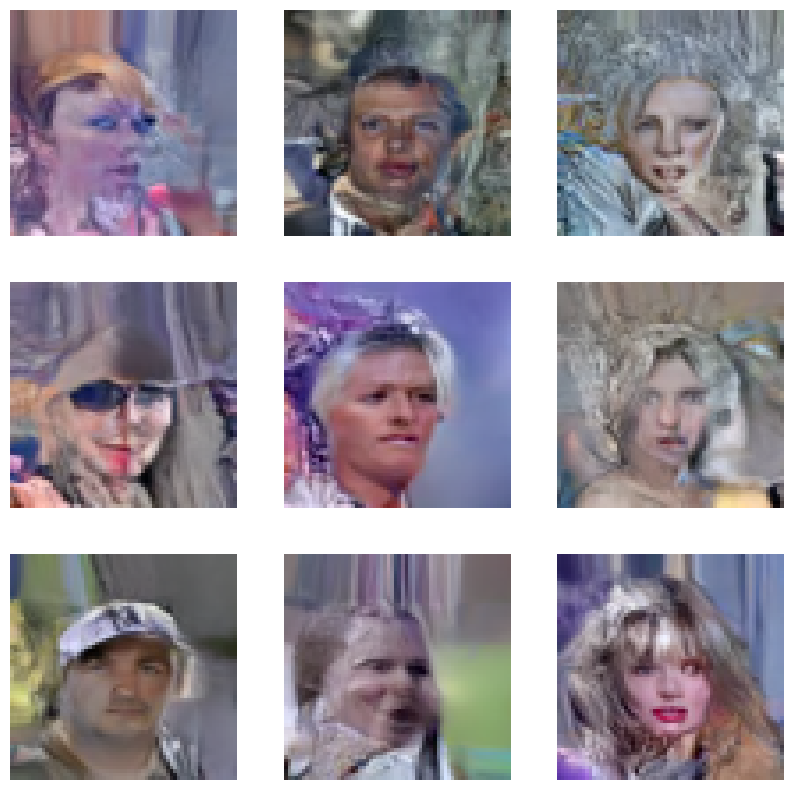

In [16]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()

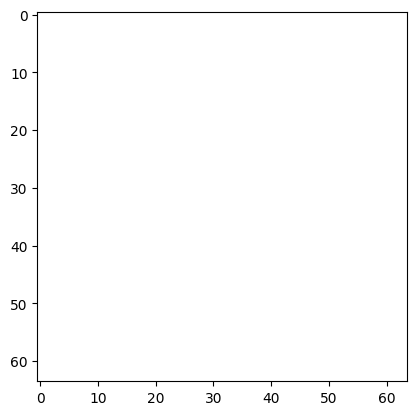

In [16]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion_relu.gif')
plt.show()